In [1]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from albumentations import *

In [4]:
def aug_image(image):
    aug = Compose([
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(shift_limit=0.06, scale_limit=0.2, rotate_limit=10, p=0.5),
        RandomBrightnessContrast(p = 0.5)
    ],p=0.7)
    image = aug(image = image)['image']
    return image

In [5]:
imagegen = ImageDataGenerator(preprocessing_function=aug_image,rescale=1./255)

In [6]:
train = imagegen.flow_from_directory("data\intel-image-classification\seg_train\seg_train",target_size=(150, 150),batch_size=32)
val = imagegen.flow_from_directory("data\intel-image-classification\seg_test\seg_test",target_size=(150, 150),batch_size=16)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout


model = Sequential()

model.add(InputLayer(input_shape = (150,150,3)))

model.add(Conv2D(32, kernel_size = (5,5), activation = 'relu', strides = (1,1), padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size = (5,5), activation = 'relu', strides = (1,1), padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', strides = (1,1), padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', strides = (1,1), padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.20))
model.add(Dense(6, activation = "softmax"))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
______________________________________

In [8]:
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

optimizer = RMSprop(lr = 0.001, rho = 0.9, epsilon = 1e-08, decay = 0.0)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [9]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [10]:
epochs = 5

In [11]:
history = model.fit_generator(train, epochs=epochs, steps_per_epoch = 5, validation_data=val, verbose = 1, callbacks=[learning_rate_reduction])


Epoch 1/5
5/5 [==============================] - 99s 20s/step - loss: 4.8498 - accuracy: 0.2188 - val_loss: 1.8309 - val_accuracy: 0.2063
Epoch 2/5
5/5 [==============================] - 108s 22s/step - loss: 2.1857 - accuracy: 0.3000 - val_loss: 1.7302 - val_accuracy: 0.1840
Epoch 3/5
5/5 [==============================] - 111s 22s/step - loss: 1.8735 - accuracy: 0.3000 - val_loss: 1.8054 - val_accuracy: 0.2313
Epoch 4/5
5/5 [==============================] - 110s 22s/step - loss: 1.5608 - accuracy: 0.4062 - val_loss: 1.8614 - val_accuracy: 0.2027
Epoch 5/5
5/5 [==============================] - 111s 22s/step - loss: 1.6031 - accuracy: 0.3750 - val_loss: 1.5831 - val_accuracy: 0.2117


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

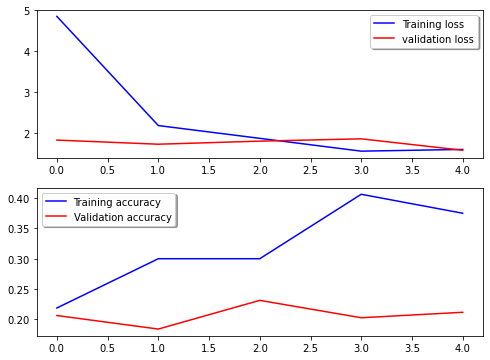

In [13]:
fig, ax = plt.subplots(2,1, figsize=(8, 6))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)